In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [2]:
cancer_data = pd.read_csv("../datasets/cancer.csv")
print(cancer_data.shape)
cancer_labels = cancer_data['label'].values
cancer_features = cancer_data.drop(['label'], axis=1).values
cancer_data.head()

(569, 31)


,label,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
blobs_data = pd.read_csv("../datasets/blobs.csv")
print(blobs_data.shape)
blobs_features = blobs_data.values
blobs_data.head()

(400, 2)


,X,Y
0,-0.727696,1.403000
1,-1.875566,0.589247
2,-0.891047,-1.399924
3,-0.224115,0.868289
4,-0.465409,0.306718


In [23]:
cancer2d = TSNE(n_components=2).fit_transform(cancer_features)
blobs2d = TSNE(n_components=2).fit_transform(blobs_features)

In [5]:
def dunn_index(X, y, norm=np.linalg.norm):
    min_outer = -1
    max_inner = 0
    for i in range(len(X)):
        for j in range(i + 1, len(X)):
            dist = norm(X[i] - X[j])
            if y[i] == y[j]:
                max_inner = max(max_inner, dist)
            else:
                if min_outer == -1:
                    min_outer = dist
                min_outer = min(min_outer, dist)
    return min_outer / max_inner

In [6]:
def purity(y_pred, y_true):
    clusters_label_count = {}
    score = 0
    count = 0
    for i, pred_label in enumerate(y_pred):
        if pred_label < 0:
            continue
        count += 1
        if pred_label not in clusters_label_count:
            clusters_label_count[pred_label] = {}
        if y_true[i] not in clusters_label_count[pred_label]:
            clusters_label_count[pred_label][y_true[i]] = 0
        clusters_label_count[pred_label][y_true[i]] += 1
    for cluster_label, true_labels in clusters_label_count.items():
        biggest_class_size = max(true_labels.values())
        score += biggest_class_size
    if count == 0:
        return 0.
    return score / count

In [7]:
def show_clusters(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.show()

In [8]:
class KMeans:
    def __init__(self, n_clusters, norm=np.linalg.norm, random_state=None):
        self.n_clusters = n_clusters
        self.norm = norm
        self.random_state = random_state
        
    def _rand_centers(self, X):
        return X[np.random.choice(np.arange(X.shape[0]), self.n_clusters)]
        
    def _new_centroids(self, X):
        sums = np.zeros_like(self.centers)
        counts = np.zeros(self.n_clusters)
        for x in X:
            nearest_label = 0
            dists_to_centers = np.array([self.norm(center - x) for center in self.centers])
            nearest_label = np.argmin(dists_to_centers)
            counts[nearest_label] += 1
            sums[nearest_label] += x
        for i in range(self.n_clusters):
            sums[i] /= counts[i]
        return sums

    def fit(self, X, max_iter=100):
        np.random.seed(self.random_state)
        self.centers = self._rand_centers(X)
        for iter_num in range(max_iter):
            self.centers = self._new_centroids(X)
        return self

    def predict(self, X):
        labels = np.zeros(X.shape[0])
        for i, x in enumerate(X):
            dists_to_centers = np.array([self.norm(center - x) for center in self.centers])
            labels[i] = np.argmin(dists_to_centers)
        return labels

Dunn index for KMeans on 2 clusters on cancer data = 0.01731113114474192


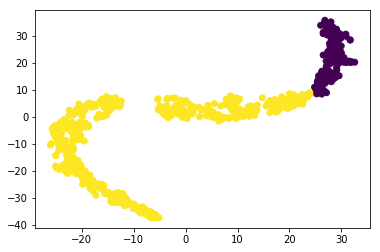

Dunn index for KMeans on 3 clusters on cancer data = 0.0046028036821627


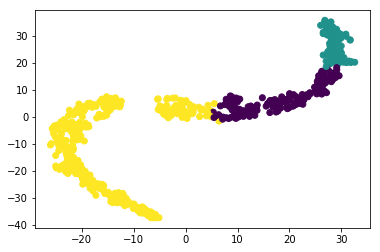

Dunn index for KMeans on 4 clusters on cancer data = 0.00992554568762757


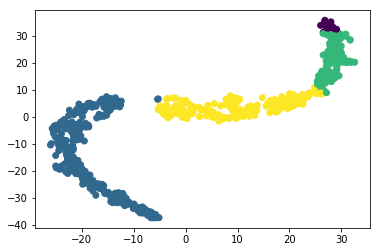

Dunn index for KMeans on 5 clusters on cancer data = 0.003931653210995027


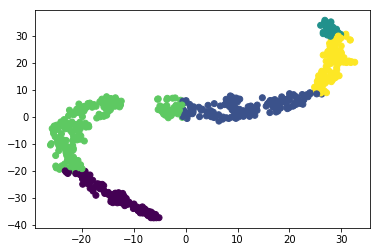

In [9]:
for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(cancer_features, max_iter=10)
    pred = kmeans.predict(cancer_features)
    score = dunn_index(cancer_features, pred)
    print(f"Dunn index for KMeans on {n_clusters} clusters on cancer data = {score}")
    show_clusters(cancer2d, pred)

Dunn index for KMeans on 2 clusters on blobs data = 0.011020999037160844


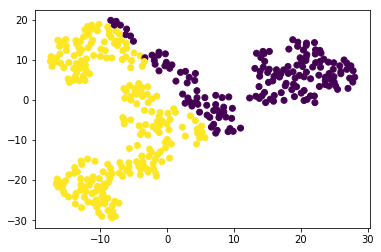

Dunn index for KMeans on 3 clusters on blobs data = 0.018869269289099568


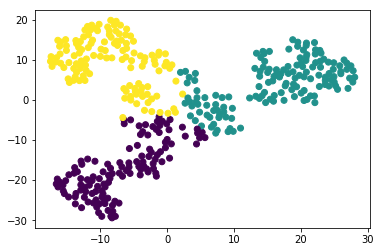

Dunn index for KMeans on 4 clusters on blobs data = 0.010480337653236305


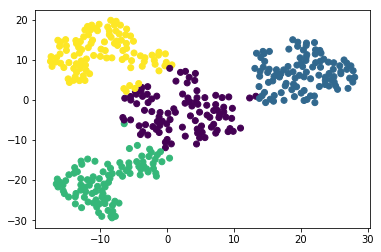

Dunn index for KMeans on 5 clusters on blobs data = 0.02680929066414224


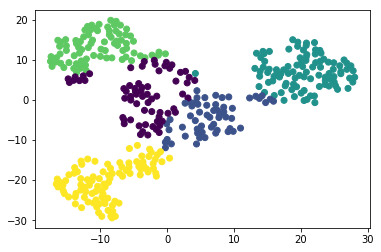

In [10]:
for n_clusters in range(2, 6):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(blobs_features, max_iter=10)
    pred = kmeans.predict(blobs_features)
    score = dunn_index(blobs_features, pred)
    print(f"Dunn index for KMeans on {n_clusters} clusters on blobs data = {score}")
    show_clusters(blobs2d, pred)

In [11]:
class DBSCAN():
    def __init__(self, minN, eps, norm=np.linalg.norm):
        self.minN = minN
        self.eps = eps
        self.norm = norm
        self.nearest = {}
        
    def _get_nearest(self, j):
        if j not in self.nearest:
            self.nearest[j] = [i for i in range(len(self.points)) if self.dists[i, j] < self.eps]
        else:
            print(j)
        return self.nearest[j]

    def _compute_dists(self):
        self.dists = np.zeros((len(self.points), len(self.points)))
        for i, x in enumerate(self.points):
            for j, y in enumerate(self.points):
                self.dists[i, j] = self.norm(y - x)
        
    def fit_predict(self, X):
        self.points = X
        self._compute_dists()
        print("computed")
        self.labels = np.ones(X.shape[0]) * -2
        self.n_clusters = 0
        for i in range(len(self.points)):
            if self.labels[i] != -2:
                continue
            nearest = self._get_nearest(i)
            if len(nearest) < self.minN:
                self.labels[i] = -1
                continue
            self.labels[i] = self.n_clusters
            cluster = set([j for j in nearest if j != i])
            while len(cluster) > 0:
                j = cluster.pop()
                if self.labels[j] == -2:
                    self.labels[j] = -1
                    j_nearest = self._get_nearest(j)
                    if len(j_nearest) >= self.minN:
                        cluster |= set(j_nearest)
                if self.labels[j] == -1:
                    self.labels[j] = self.n_clusters
            self.n_clusters += 1
        return self.labels

computed
Dunn index for DBSCAN on (5, 11.78) on cancer data = 0.0012447407548986159
num of clusters = 4


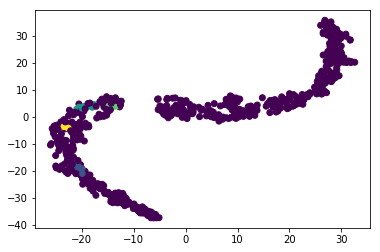

In [13]:
minN = 5
eps = 11.78  # binary search for fixed minN on interval [5; 15]. minN selected randomly
dbscan = DBSCAN(minN=minN, eps=eps)
pred = dbscan.fit_predict(cancer_features)
score = dunn_index(cancer_features, pred)
print(f"Dunn index for DBSCAN on ({minN}, {eps}) on cancer data = {score}")
print(f"num of clusters = {dbscan.n_clusters}")
show_clusters(cancer2d, pred)

computed
Dunn index for DBSCAN on (3, 0.3) on blobs data = 0.06227077585710698
num of clusters = 4


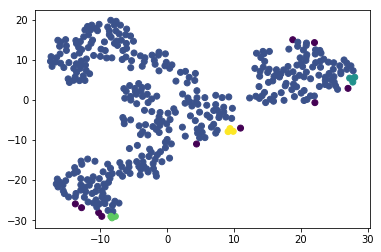

In [15]:
minN = 3
eps = 0.3
'''
(5, 11.78) - 1
(5, 5) - 1
(5, 1) - 1
(3, 1) - 1
(3, 0.2) - 7
(3, 0.3) - 4
'''
dbscan = DBSCAN(minN=minN, eps=eps)
pred = dbscan.fit_predict(blobs_features)
score = dunn_index(blobs_features, pred)
print(f"Dunn index for DBSCAN on ({minN}, {eps}) on blobs data = {score}")
print(f"num of clusters = {dbscan.n_clusters}")
show_clusters(blobs2d, pred)

In [16]:
class AgglomerativeClustering:
    def __init__(self, norm=np.linalg.norm):
        self.norm = norm
        
    def _find_nearest(self):
        centers = np.array([s / len(c) for s, c in zip(self.sum, self.clusters)])
        min_dist = self.norm(centers[0] - centers[1])
        arg_min = (0, 1)
        for i in range(len(self.clusters)):
            for j in range(i + 1, len(self.clusters)):
                if min_dist > self.norm(centers[i] - centers[j]):
                    min_dist = self.norm(centers[i] - centers[j])
                    arg_min = (i, j)
        return arg_min
    
    def init(self, X):
        self.points = X
        self.clusters = [set([i]) for i in range(len(X))]
        self.sum = [p for p in X]
    
    def fit(self, n_clusters):
        while len(self.clusters) > n_clusters:
            i, j = self._find_nearest()
            self.clusters.append(self.clusters[i] | self.clusters[j])
            del self.clusters[i]
            del self.clusters[j]
            self.sum.append(self.sum[i] + self.sum[j])
            del self.sum[i]
            del self.sum[j]
            
    def predict(self):
        labels = np.zeros(len(self.points))
        cluster_label = 0
        for cluster in self.clusters:
            for i in cluster:
                labels[i] = cluster_label
            cluster_label += 1
        return labels
                          
    def fit_predict(self, n_clusters):
        self.fit(n_clusters)
        return self.predict()
    
    def cluster_labels(self):
        return list(range(len(self.clusters)))

Dunn index for Agglomerative Clustering on 5 clusters on cancer data = 0.0022823681230865344


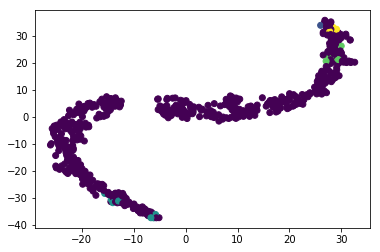

Dunn index for Agglomerative Clustering on 4 clusters on cancer data = 0.0022823681230865344


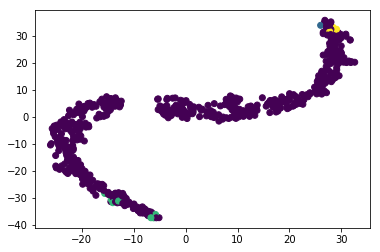

Dunn index for Agglomerative Clustering on 3 clusters on cancer data = 0.018853671586459966


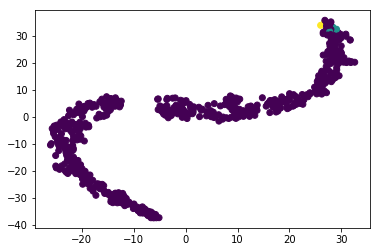

Dunn index for Agglomerative Clustering on 2 clusters on cancer data = 0.051151819503521975


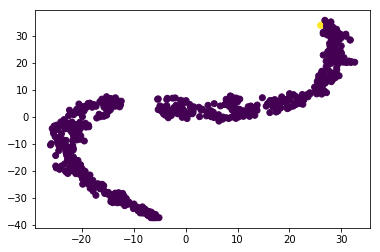

In [17]:
agg = AgglomerativeClustering()
agg.init(cancer_features)
for n_clusters in range(5, 1, -1):
    pred = agg.fit_predict(n_clusters)
    score = dunn_index(cancer_features, pred)
    print(f"Dunn index for Agglomerative Clustering on {n_clusters} clusters on cancer data = {score}")
    show_clusters(cancer2d, pred)

Dunn index for Agglomerative Clustering on 5 clusters on blobs data = 0.01580078058974727


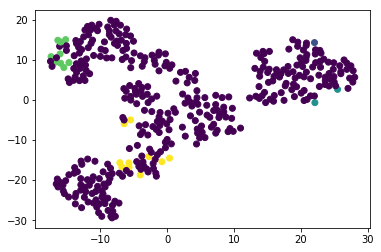

Dunn index for Agglomerative Clustering on 4 clusters on blobs data = 0.01580078058974727


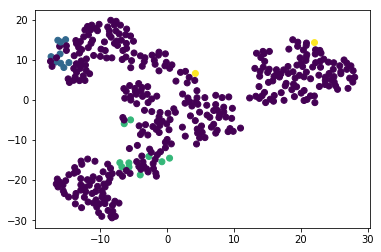

Dunn index for Agglomerative Clustering on 3 clusters on blobs data = 0.01580078058974727


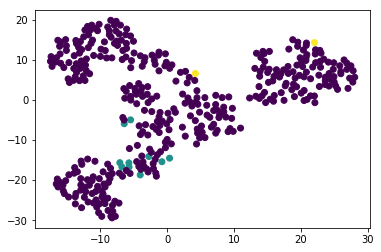

Dunn index for Agglomerative Clustering on 2 clusters on blobs data = 0.015281081577689414


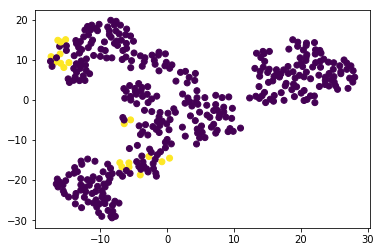

In [18]:
agg = AgglomerativeClustering()
agg.init(blobs_features)
for n_clusters in range(5, 1, -1):
    pred = agg.fit_predict(n_clusters)
    score = dunn_index(blobs_features, pred)
    print(f"Dunn index for Agglomerative Clustering on {n_clusters} clusters on blobs data = {score}")
    show_clusters(blobs2d, pred)

In [19]:
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(cancer_features, max_iter=10)
    pred = kmeans.predict(cancer_features)
    print(f"purity for KMeans on {n_clusters} clusters on cancer data = {purity(y_pred=pred, y_true=cancer_labels)}")

purity for KMeans on 2 clusters on cancer data = 0.8541300527240774
purity for KMeans on 3 clusters on cancer data = 0.8875219683655536
purity for KMeans on 4 clusters on cancer data = 0.8488576449912126
purity for KMeans on 5 clusters on cancer data = 0.9103690685413005
purity for KMeans on 6 clusters on cancer data = 0.8998242530755711
purity for KMeans on 7 clusters on cancer data = 0.8857644991212654
purity for KMeans on 8 clusters on cancer data = 0.8980667838312829
purity for KMeans on 9 clusters on cancer data = 0.8875219683655536
purity for KMeans on 10 clusters on cancer data = 0.8963093145869947


In [20]:
cancer_normed_features = MinMaxScaler().fit_transform(cancer_features)
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(cancer_normed_features, max_iter=10)
    pred = kmeans.predict(cancer_normed_features)
    print(f"purity for KMeans on {n_clusters} clusters on normed cancer data = {purity(y_pred=pred, y_true=cancer_labels)}")

purity for KMeans on 2 clusters on normed cancer data = 0.9279437609841827
purity for KMeans on 3 clusters on normed cancer data = 0.8822495606326889
purity for KMeans on 4 clusters on normed cancer data = 0.8927943760984183
purity for KMeans on 5 clusters on normed cancer data = 0.9173989455184535
purity for KMeans on 6 clusters on normed cancer data = 0.9384885764499121
purity for KMeans on 7 clusters on normed cancer data = 0.9033391915641477
purity for KMeans on 8 clusters on normed cancer data = 0.9367311072056239
purity for KMeans on 9 clusters on normed cancer data = 0.9384885764499121
purity for KMeans on 10 clusters on normed cancer data = 0.9420035149384886
